In [8]:
import sys
import numpy as np
import pandas as pd
import os 
import gc
from tqdm import tqdm, tqdm_notebook 
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import LabelEncoder
import datetime
import time
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.externals import joblib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

path = 'D:/1MyDocument/CarSalesPrediction/'
train_sales  = pd.read_csv(path+'train2_dataset/train_sales_data.csv',converters={'salesVolume': lambda u: np.log1p(float(u)) if float(u) > 0 else 0})
train_search = pd.read_csv(path+'train2_dataset/train_search_data.csv',converters={'popularity': lambda u: np.log1p(float(u)) if float(u) > 0 else 0})
train_user   = pd.read_csv(path+'train2_dataset/train_user_reply_data.csv',converters={'carCommentVolum': lambda u: np.log1p(float(u)) if float(u) > 0 else 0,
                                                                           'newsReplyVolum': lambda u: np.log1p(float(u)) if float(u) > 0 else 0})
# train_sales  = pd.read_csv(path+'train2_dataset/train_sales_data.csv')
# train_search = pd.read_csv(path+'train2_dataset/train_search_data.csv')
# train_user   = pd.read_csv(path+'train2_dataset/train_user_reply_data.csv')
# evaluation_public = pd.read_csv(path+'test2_dataset/evaluation_public.csv')
data = pd.concat([train_sales, evaluation_public], ignore_index=True)
data = data.merge(train_search, 'left', on=['province', 'adcode', 'model', 'regYear', 'regMonth'])
data = data.merge(train_user, 'left', on=['model', 'regYear', 'regMonth'])

data['label'] = data['salesVolume']
data['id'] = data['id'].fillna(0).astype(int)
data['bodyType'] = data['model'].map(train_sales.drop_duplicates('model').set_index('model')['bodyType'])

for i in ['bodyType', 'model']:
    data[i] = data[i].map(dict(zip(data[i].unique(), range(data[i].nunique()))))
data['mt'] = (data['regYear'] - 2016) * 12 + data['regMonth']
day_map = {1:31,2:28,3:31,4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
data['dayCount'] = data['regMonth'].map(day_map)
data.loc[(data.regMonth==2)&(data.regYear==2016),'dayCount']=29

# for catg in ['adcode','bodyType','model','regMonth','dayCount']:
#     data[catg+'1'] = data[catg]
# from sklearn.preprocessing import LabelEncoder
# cols = ('adcode1','bodyType1','model1','regMonth1','dayCount1')
# # process columns, apply LabelEncoder to categorical features
# for c in cols:
#     lbl = LabelEncoder() 
#     lbl.fit(list(data[c].values))
#     data[c] = lbl.transform(list(data[c].values))

In [2]:
def get_stat_feature(df_,): 
    df = df_.copy()
    stat_feat = []
    stat_feat_2=[]
    stat_feat_3 = []
    stat_feat_4 = []
    df['model_adcode'] = df['adcode'] + df['model']
    df['model_adcode_mt'] = df['model_adcode'] * 100 + df['mt']
    for col in ['label']:
        # 历史销量数据特征
        for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]:
            stat_feat.append('shift_model_adcode_mt_{}_{}'.format(col,i))
            df['model_adcode_mt_{}_{}'.format(col,i)] = df['model_adcode_mt'] + i
            df_last = df[~df[col].isnull()].set_index('model_adcode_mt_{}_{}'.format(col,i))
            df['shift_model_adcode_mt_{}_{}'.format(col,i)] = df['model_adcode_mt'].map(df_last[col])
    for col in ['popularity','carCommentVolum','newsReplyVolum']:
        # 历史popularity数据特征
        for i in [5,10,11,12]:
            stat_feat.append('shift_model_adcode_mt_{}_{}'.format(col,i))
            df['model_adcode_mt_{}_{}'.format(col,i)] = df['model_adcode_mt'] + i
            df_last = df[~df[col].isnull()].set_index('model_adcode_mt_{}_{}'.format(col,i))
            df['shift_model_adcode_mt_{}_{}'.format(col,i)] = df['model_adcode_mt'].map(df_last[col])
    
    pairs = [(1,13), (2,14), (3,15), (4,16)]
    for col in ['label']:
        # 比去年同期增长多少(同比一年前的增长)
        for pair in pairs:
            stat_feat.append('increase_{}_{}_{}'.format(col,pair[0],pair[1]))
            df['increase_{}_{}_{}'.format(col,pair[0],pair[1])] = (df['shift_model_adcode_mt_{}_{}'.format(col,pair[0])]-
                df['shift_model_adcode_mt_{}_{}'.format(col,pair[1])])/df['shift_model_adcode_mt_{}_{}'.format(col,pair[1])]
        # 过去一段时间的mean, max, median, min, std, diff
        for width in [(1,4), (1,7), (1,5), (7,13), (3,6), (3,9)]:
            item = []
            for ii in range(width[0],width[1]):
                item.append('shift_model_adcode_mt_{}_{}'.format(col,ii))
            df['diff_{}_{}'.format(col,width)] = df[item].diff(axis=1).mean(axis=1)
            stat_feat.append('diff_{}_{}'.format(col,width))
            df['mean_{}_{}'.format(col,width)] = df[item].mean(axis=1)
            stat_feat.append('mean_{}_{}'.format(col,width))
            df['max_{}_{}'.format(col,width)] = df[item].max(axis=1)
            stat_feat.append('max_{}_{}'.format(col,width))
            df['min_{}_{}'.format(col,width)] = df[item].min(axis=1)
            stat_feat.append('min_{}_{}'.format(col,width))
            df['std_{}_{}'.format(col,width)] = df[item].std(axis=1)
            stat_feat.append('std_{}_{}'.format(col,width))
            df['median_{}_{}'.format(col,width)] = df[item].median(axis=1)
            stat_feat.append('median_{}_{}'.format(col,width))

        # 按车型或省份每月mean和min
        for ind in [1,2,3,4,5,6,7,8,9,10,11,12]:
            stat_feat.append('Mean_model_{}_{}'.format(col,ind))
            stat_feat.append('Min_model_{}_{}'.format(col,ind))
            stat_feat.append('Median_model_{}_{}'.format(col,ind))
            stat_feat.append('Max_model_{}_{}'.format(col,ind))
            stat_feat.append('Std_model_{}_{}'.format(col,ind))
            # stat_feat.append('Diff_model_{}_{}'.format(col,ind))
            
            mean = pd.DataFrame(df.groupby(['model','mt'])['shift_model_adcode_mt_{}_{}'.format(col,ind)].mean()).rename(
                columns={'shift_model_adcode_mt_{}_{}'.format(col,ind):'Mean_model_{}_{}'.format(col,ind)})
            df = pd.merge(df,mean,on=["model","mt"],how="left")
            min_ = pd.DataFrame(df.groupby(['model','mt'])['shift_model_adcode_mt_{}_{}'.format(col,ind)].min()).rename(
                columns={'shift_model_adcode_mt_{}_{}'.format(col,ind):'Min_model_{}_{}'.format(col,ind)})
            df = pd.merge(df,min_,on=["model","mt"],how="left")
            max_ = pd.DataFrame(df.groupby(['model','mt'])['shift_model_adcode_mt_{}_{}'.format(col,ind)].max()).rename(
                columns={'shift_model_adcode_mt_{}_{}'.format(col,ind):'Max_model_{}_{}'.format(col,ind)})
            df = pd.merge(df,max_,on=["model","mt"],how="left")
            median_ = pd.DataFrame(df.groupby(['model','mt'])['shift_model_adcode_mt_{}_{}'.format(col,ind)].median()).rename(
                columns={'shift_model_adcode_mt_{}_{}'.format(col,ind):'Median_model_{}_{}'.format(col,ind)})
            df = pd.merge(df,median_,on=["model","mt"],how="left")
            std_ = pd.DataFrame(df.groupby(['model','mt'])['shift_model_adcode_mt_{}_{}'.format(col,ind)].std()).rename(
                columns={'shift_model_adcode_mt_{}_{}'.format(col,ind):'Std_model_{}_{}'.format(col,ind)})
            df = pd.merge(df,std_,on=["model","mt"],how="left")
            # diff_ = pd.DataFrame(df.groupby(['model','mt'])['shift_model_adcode_mt_{}_{}'.format(col,ind)].diff().mean()).rename(
            #     columns={'shift_model_adcode_mt_{}_{}'.format(col,ind):'Diff_model_{}_{}'.format(col,ind)})
            # df = pd.merge(df,diff_,on=["model","mt"],how="left")
            
            stat_feat.append('Mean_adcode_{}_{}'.format(col,ind))
            stat_feat.append('Min_adcode_{}_{}'.format(col,ind))
            stat_feat.append('Median_adcode_{}_{}'.format(col,ind))
            stat_feat.append('Max_adcode_{}_{}'.format(col,ind))
            stat_feat.append('Std_adcode_{}_{}'.format(col,ind))
            # stat_feat.append('Diff_adcode_{}_{}'.format(col,ind))
            mean = pd.DataFrame(df.groupby(['adcode','mt'])['shift_model_adcode_mt_{}_{}'.format(col,ind)].mean()).rename(
                columns={'shift_model_adcode_mt_{}_{}'.format(col,ind):'Mean_adcode_{}_{}'.format(col,ind)})
            df = pd.merge(df,mean,on=["adcode","mt"],how="left")
            min_ = pd.DataFrame(df.groupby(['adcode','mt'])['shift_model_adcode_mt_{}_{}'.format(col,ind)].min()).rename(
                columns={'shift_model_adcode_mt_{}_{}'.format(col,ind):'Min_adcode_{}_{}'.format(col,ind)})
            df = pd.merge(df,min_,on=["adcode","mt"],how="left")
            max_ = pd.DataFrame(df.groupby(['adcode','mt'])['shift_model_adcode_mt_{}_{}'.format(col,ind)].max()).rename(
                columns={'shift_model_adcode_mt_{}_{}'.format(col,ind):'Max_adcode_{}_{}'.format(col,ind)})
            df = pd.merge(df,max_,on=["adcode","mt"],how="left")
            median_ = pd.DataFrame(df.groupby(['adcode','mt'])['shift_model_adcode_mt_{}_{}'.format(col,ind)].median()).rename(
                columns={'shift_model_adcode_mt_{}_{}'.format(col,ind):'Median_adcode_{}_{}'.format(col,ind)})
            df = pd.merge(df,median_,on=["adcode","mt"],how="left")
            std_ = pd.DataFrame(df.groupby(['adcode','mt'])['shift_model_adcode_mt_{}_{}'.format(col,ind)].std()).rename(
                columns={'shift_model_adcode_mt_{}_{}'.format(col,ind):'Std_adcode_{}_{}'.format(col,ind)})
            df = pd.merge(df,std_,on=["adcode","mt"],how="left")
            # diff_ = pd.DataFrame(df.groupby(['adcode','mt'])['shift_model_adcode_mt_{}_{}'.format(col,ind)].diff().mean()).rename(
            #   columns={'shift_model_adcode_mt_{}_{}'.format(col,ind):'Diff_adcode_{}_{}'.format(col,ind)})
            # df = pd.merge(df,diff_,on=["adcode","mt"],how="left")
    pairs = [(1,4), (1,6), (1,12), (3,6), (3,12),(3,9)]
    for col in ['label']:
        # mean model/adcode 增长比例
        for pair in pairs:
            stat_feat.append('increase_mean_model_{}_{}_{}'.format(col,pair[0],pair[1]))
            df['increase_mean_model_{}_{}_{}'.format(col,pair[0],pair[1])] = (df['Mean_model_{}_{}'.format(col,pair[0])]-
                df['Mean_model_{}_{}'.format(col,pair[1])])/df['Mean_model_{}_{}'.format(col,pair[1])]
            stat_feat.append('increase_mean_adcode_{}_{}_{}'.format(col,pair[0],pair[1]))
            df['increase_mean_adcode_{}_{}_{}'.format(col,pair[0],pair[1])] = (df['Mean_adcode_{}_{}'.format(col,pair[0])]-
                df['Mean_adcode_{}_{}'.format(col,pair[1])])/df['Mean_adcode_{}_{}'.format(col,pair[1])]
    
    for col in ['label']:
        # sum求和
        ind = 0
        for pair in [(1,2,11,12),(1,2,3),(1,12)]:
            stat_feat.append('sum_{}_{}'.format(col,ind))
            df['sum_{}_{}'.format(col,ind)] = 0
            length = len(pair)
            for i in range(length):
                df['sum_{}_{}'.format(col,ind)] += df["shift_model_adcode_mt_{}_{}".format(col,pair[i])].values
            ind += 1
            
    # 删除特征
    # stat_feat.remove("shift_model_adcode_mt_label_15")
    return df,stat_feat

In [3]:
# df, stat_feat = get_stat_feature(data)

In [4]:
# len(stat_feat),len(set(stat_feat))

(203, 203)


 mu = 5.63 and sigma = 1.14



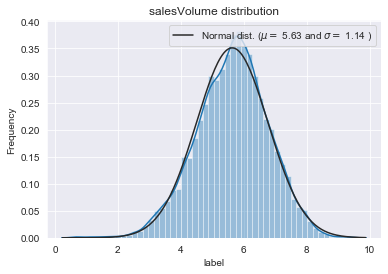

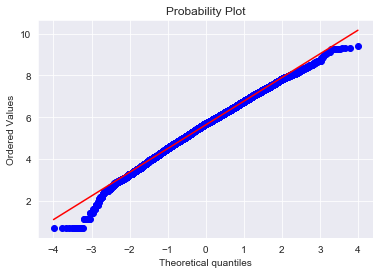

In [9]:
# salesVolume distribution and Quantile-Quantile plot(QQ)
st = 13 #start time 
all_idx = (data['mt'].between(st, 24))
all_y = data[all_idx]['label']
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm, skew #for some statistics
# Get the fitted parameters used by the function
# all_y = np.expm1(all_y)
sns.distplot(all_y, fit=norm)
(mu, sigma) = norm.fit(all_y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('salesVolume distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(all_y, plot=plt)
plt.show()

In [12]:
len(stat_feat),len(set(stat_feat))

(203, 203)

In [8]:
data[['dayCount1','adcode']].head()

,dayCount1,adcode
0,3,310000
1,3,530000
2,3,150000
3,3,110000
4,3,510000


In [6]:
# 特征选取
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

clf = RandomForestRegressor(n_estimators=500, min_samples_split=3, min_samples_leaf=10)
clf = clf.fit(all_x, all_y)
feature_importances = clf.feature_importances_  

In [7]:
import torch
feature_importances = torch.from_numpy(clf.feature_importances_)
_,ind = feature_importances.topk(180)
ind = ind.numpy().tolist()
ind

[202,
 201,
 200,
 0,
 13,
 35,
 12,
 37,
 33,
 24,
 25,
 20,
 69,
 26,
 9,
 27,
 14,
 16,
 118,
 21,
 171,
 6,
 45,
 18,
 22,
 70,
 23,
 71,
 49,
 170,
 17,
 15,
 19,
 163,
 7,
 186,
 79,
 169,
 161,
 184,
 183,
 179,
 64,
 131,
 1,
 168,
 154,
 159,
 101,
 160,
 52,
 139,
 74,
 180,
 68,
 81,
 181,
 11,
 129,
 10,
 5,
 141,
 89,
 164,
 174,
 158,
 55,
 124,
 65,
 149,
 134,
 108,
 178,
 121,
 53,
 80,
 34,
 119,
 51,
 3,
 111,
 173,
 109,
 63,
 144,
 8,
 84,
 151,
 104,
 91,
 99,
 120,
 114,
 110,
 157,
 94,
 185,
 150,
 2,
 130,
 152,
 76,
 58,
 78,
 90,
 57,
 4,
 67,
 128,
 88,
 40,
 116,
 122,
 59,
 166,
 39,
 47,
 140,
 103,
 146,
 138,
 41,
 117,
 187,
 147,
 85,
 72,
 148,
 126,
 136,
 46,
 165,
 143,
 98,
 73,
 61,
 156,
 77,
 175,
 176,
 43,
 100,
 133,
 137,
 96,
 86,
 127,
 142,
 145,
 113,
 105,
 75,
 106,
 83,
 93,
 97,
 82,
 167,
 95,
 135,
 115,
 177,
 87,
 112,
 155,
 107,
 123,
 125,
 92,
 153,
 172,
 182,
 102,
 132,
 162,
 60,
 28,
 32,
 54,
 50]

In [8]:
all_x.head()

,shift_model_adcode_mt_label_1,shift_model_adcode_mt_label_2,shift_model_adcode_mt_label_3,shift_model_adcode_mt_label_4,shift_model_adcode_mt_label_5,shift_model_adcode_mt_label_6,shift_model_adcode_mt_label_7,shift_model_adcode_mt_label_8,shift_model_adcode_mt_label_9,shift_model_adcode_mt_label_10,...,increase_mean_adcode_label_1_12,increase_mean_model_label_3_6,increase_mean_adcode_label_3_6,increase_mean_model_label_3_12,increase_mean_adcode_label_3_12,increase_mean_model_label_3_9,increase_mean_adcode_label_3_9,sum_label_0,sum_label_1,sum_label_2
15840,5,5,5,5,5,5,5,5,5,5,...,0,0,0,0,0,0,0,22,17,11
15841,6,5,5,5,5,6,5,5,5,5,...,0,0,0,0,0,0,0,23,17,12
15842,5,5,5,5,5,5,5,5,5,5,...,0,0,0,0,0,0,0,21,15,10
15843,6,6,5,5,5,5,5,6,6,5,...,0,0,0,0,0,0,0,23,18,12
15844,6,6,5,6,5,5,5,5,5,5,...,0,0,0,0,0,0,0,24,18,12


In [9]:
df.loc[(df.regMonth==5)&(df.regYear==2017), stat_feat].head()

,shift_model_adcode_mt_label_1,shift_model_adcode_mt_label_2,shift_model_adcode_mt_label_3,shift_model_adcode_mt_label_4,shift_model_adcode_mt_label_5,shift_model_adcode_mt_label_6,shift_model_adcode_mt_label_7,shift_model_adcode_mt_label_8,shift_model_adcode_mt_label_9,shift_model_adcode_mt_label_10,...,increase_mean_adcode_label_1_12,increase_mean_model_label_3_6,increase_mean_adcode_label_3_6,increase_mean_model_label_3_12,increase_mean_adcode_label_3_12,increase_mean_model_label_3_9,increase_mean_adcode_label_3_9,sum_label_0,sum_label_1,sum_label_2
21120,5.579730,5.736572,5.267858,5.723585,5.926926,5.913503,5.433722,5.583496,5.093750,5.564520,...,-0.041701,-0.100572,-0.169765,-0.079696,-0.111331,-0.025563,-0.136450,22.385936,16.584160,11.185532
21121,5.497168,5.713733,5.273000,6.075346,6.124683,5.998937,5.739793,5.384495,5.509388,6.040255,...,-0.038748,-0.100572,-0.107835,-0.079696,-0.059120,-0.025563,-0.078637,22.579032,16.483901,11.230510
21122,5.176150,5.308268,4.859812,5.198497,5.393628,5.323010,5.187386,5.062595,5.036953,5.236442,...,-0.029765,-0.100572,-0.136060,-0.079696,-0.101130,-0.025563,-0.094854,21.058423,15.344230,10.644210
21123,5.831882,6.159095,6.070738,6.150603,6.335054,6.133398,5.918894,5.823046,5.501258,5.777652,...,-0.123413,-0.100572,-0.176136,-0.079696,-0.163204,-0.025563,-0.164408,23.954928,18.061716,11.932201
21124,5.823046,5.937536,5.537334,6.216606,6.347389,6.118097,5.860786,6.436150,5.846439,5.817111,...,-0.029363,-0.100572,-0.086476,-0.079696,-0.048710,-0.025563,-0.065441,23.448553,17.297916,11.711924


In [11]:
def score(data, pred='pred_label', label='n_label', group='model'):
    data['pred_label'] = data['pred_label'].apply(lambda x: 0 if x < 0 else x).round().astype(int)
    data_agg = data.groupby('model').agg({
        pred:  list,
        label: [list, 'mean']
    }).reset_index()
    data_agg.columns = ['_'.join(col).strip() for col in data_agg.columns]
    nrmse_score = []
    for raw in data_agg[['{0}_list'.format(pred), '{0}_list'. format(label), '{0}_mean'.format(label)]].values:
        nrmse_score.append(mse(raw[0], raw[1]) ** 0.5 / raw[2] )
    print(1 - np.mean(nrmse_score))
    return 1 - np.mean(nrmse_score)

def get_model_type(train_x,train_y,valid_x,valid_y,m_type='lgb',i=0):   
    if m_type == 'lgb':
        model = lgb.LGBMRegressor(
                                num_leaves=2**5-1, reg_alpha=0.25, reg_lambda=0.25, objective='mse',
                                max_depth=-1, learning_rate=0.01, min_child_samples=10, random_state=2019,
                                n_estimators=4000, subsample=0.9, colsample_bytree=0.7,num_threads= -1,
                                )
        model.fit(train_x, train_y, 
              eval_set=[(train_x, train_y),(valid_x, valid_y)], 
              categorical_feature=cate_feat,
              early_stopping_rounds=100, verbose=100)
    elif m_type == 'xgb':
        model = xgb.XGBRegressor(
                                max_depth=5 , learning_rate=0.005, n_estimators=4000, 
                                objective='reg:gamma', tree_method = 'hist',subsample=0.9, 
                                colsample_bytree=0.7, min_child_samples=5,eval_metric = 'rmse' 
                                )
        model.fit(train_x, train_y, 
              eval_set=[(train_x, train_y),(valid_x, valid_y)], 
              early_stopping_rounds=100, verbose=100)   
    return model
def get_train_model(df_, m, m_type='lgb',i=0):
    df = df_.copy()
    st = 13 #start time 
    all_idx   = (df['mt'].between(st , m-1))
    train_idx = (df['mt'].between(st , m-5))
    valid_idx = (df['mt'].between(m-4, m-4))
    test_idx  = (df['mt'].between(m  , m  ))
    train_x = df[train_idx][features]
    train_y = df[train_idx]['label']
    valid_x = df[valid_idx][features]
    valid_y = df[valid_idx]['label']

    # get model
    model = get_model_type(train_x,train_y,valid_x,valid_y,m_type,i)  
    # offline
    df['pred_label'] = np.expm1(model.predict(df[features]))
    best_score = score(df[valid_idx]) 
    # online
    if m_type == 'lgb':
        model.n_estimators = model.best_iteration_ + 100
        model.fit(df[all_idx][features], df[all_idx]['label'])
    elif m_type == 'xgb':
        model.n_estimators = model.best_iteration + 100
        model.fit(df[all_idx][features], df[all_idx]['label'])
    #     df['forecastVolum'] = np.expm1(model.predict(df[features]))
    df['forecastVolum'] = model.predict(df[features])
    # 阶段结果
    sub = df[test_idx][['id']]
    sub['forecastVolum'] = df[test_idx]['forecastVolum'].apply(lambda x: 0 if x < 0 else x).round(8)
    return sub,df[valid_idx]['pred_label']

In [12]:
for month in [25,26,27,28]: 
    m_type = 'lgb' 
    data['n_label'] = np.expm1(data['label'])
    data_df, stat_feat = get_stat_feature(data) #每次都要更新下特征
    feat = [stat_feat[i] for i in pre]
    num_feat = ['regYear'] + feat
    cate_feat = ['adcode','bodyType','model','regMonth',]#,'k_mean_1','k_mean'
    if m_type == 'lgb':
        for i in cate_feat:
            data_df[i] = data_df[i].astype('category')
    elif m_type == 'xgb':
        lbl = LabelEncoder()  
        for i in tqdm(cate_feat):
            data_df[i] = lbl.fit_transform(data_df[i].astype(str)) 
    features = num_feat + cate_feat
    print(len(features), len(set(features)))   
    sub,val_pred = get_train_model(data_df, month, m_type,month-24)   
    data.loc[(data.regMonth==(month-24))&(data.regYear==2018), 'salesVolume'] =  np.expm1(sub['forecastVolum'].values)
    data.loc[(data.regMonth==(month-24))&(data.regYear==2018), 'label'      ] = sub['forecastVolum'].values
sub = data.loc[(data.regMonth>=1)&(data.regYear==2018), ['id','salesVolume']]
sub.columns = ['id','forecastVolum']
sub[['id','forecastVolum']].round().astype(int).to_csv('tmp_result.csv', index=False)
# 结果基于规则纠正
my_data=pd.read_csv('tmp_result.csv')
my_data["forecastVolum"]=my_data["forecastVolum"]*0.8
my_data["forecastVolum"]=(my_data["forecastVolum"]).astype(int)
my_data.to_csv('lgb_submit.csv',index=0)

185 185
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.239272	valid_1's l2: 0.23972
[200]	training's l2: 0.0845497	valid_1's l2: 0.0831245
[300]	training's l2: 0.0520865	valid_1's l2: 0.0601425
[400]	training's l2: 0.040309	valid_1's l2: 0.0567441
[500]	training's l2: 0.0338107	valid_1's l2: 0.0563208
Early stopping, best iteration is:
[464]	training's l2: 0.0357732	valid_1's l2: 0.0562624
lgb_model_1 has saved
0.7451689806193338
(1804, 2)
185 185
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 0.239148	valid_1's l2: 0.262686
[200]	training's l2: 0.0842148	valid_1's l2: 0.105448
[300]	training's l2: 0.0524096	valid_1's l2: 0.0821693
[400]	training's l2: 0.0412212	valid_1's l2: 0.0788097
[500]	training's l2: 0.0350217	valid_1's l2: 0.0778405
[600]	training's l2: 0.0307167	valid_1's l2: 0.0765151
[700]	training's l2: 0.0275997	valid_1's l2: 0.0756988
[800]	training's l2: 0.0252627	valid_1's l2: 0.0747734
[900]	train